In [2]:
import pandas as pd
import numpy as np
import sys

# The dataset

In [3]:
from datasets import load_dataset, List
emotions_dict = load_dataset("emotion")
emotions_dict

/home/daniel/projects/git/organizations/data-science-adventure/information-extraction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
# Create a dummy CSV file for the example
pd.DataFrame({
    'text': ["This is great.", "This is terrible.", "So-so."],
    'label': [1, 0, 1]
}).to_csv("my_data.csv", index=False)

# Load the local CSV file
local_dataset = load_dataset("csv", data_files="my_data.csv")

print(local_dataset)
print(local_dataset["train"][0])

Generating train split: 3 examples [00:00, 971.35 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3
    })
})
{'text': 'This is great.', 'label': 1}


In [9]:
from datasets import Dataset

# Create a dataset from a dictionary
data = {
    "sentence": ["Hello, world!", "Coding is fun."],
    "id": [1, 2]
}
my_dataset = Dataset.from_dict(data)

print(my_dataset)
print(my_dataset[::])

Dataset({
    features: ['sentence', 'id'],
    num_rows: 2
})
{'sentence': ['Hello, world!', 'Coding is fun.'], 'id': [1, 2]}


In [ ]:
train_ds = emotions_dict['train']

print(emotions_dict['train'].features["label"])
train_ds[::]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])


{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was',
  'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
  'i feel as confused about life as a teenager or as jaded as a year old man',
  'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
  'i feel romantic too',
  'i feel like i have to make the suffering i m seeing mean something',
  'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
  'i think it s the easiest time of year to feel dissatisfied',
  'i feel low 

In [4]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [5]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [6]:
print(tokenizer.convert_tokens_to_string(tokens))
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
tokenizer.vocab_size

[CLS] tokenizing text is a core task of nlp. [SEP]
30522
512


30522

In [7]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))


emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [8]:
from transformers import AutoModel
import torch
import torch.nn.functional as F
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

if torch.cuda.is_available():
    print("CUDA is loaded")
else: 
    print("CPU is used")

CPU is used


In [9]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [10]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [11]:
emotions_hidden["train"].column_names


['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Feature matrix

In [12]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

## Visualizing the training set

In [13]:
import umap.umap_ as umap

# Create a UMAP reducer object
reducer = umap.UMAP()

# Example usage with data (replace with your actual data)
# embedding = reducer.fit_transform(your_data)


import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()



,X,Y,label
0,4.156853,6.084805,0
1,-3.188735,5.559969,0
2,5.363002,2.618664,3
3,-2.409425,3.555258,2
4,-3.515545,3.477198,3


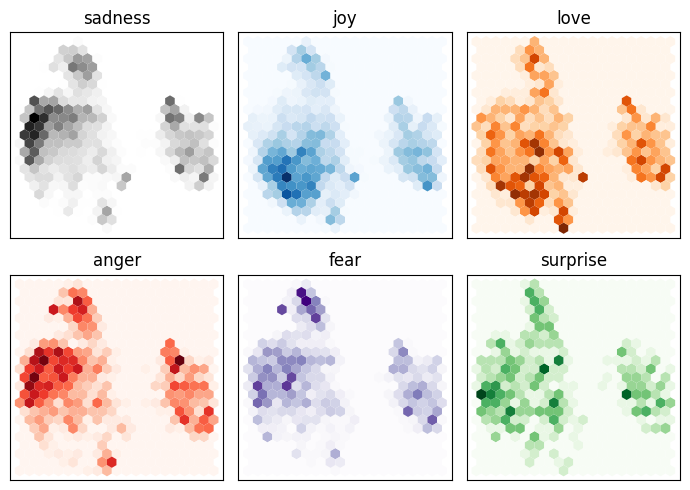

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

## Training

In [15]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergencelr_clf = LogisticRegression(max_iter=3000)
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

## Dummy classifier

In [16]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

## Confusion matrix

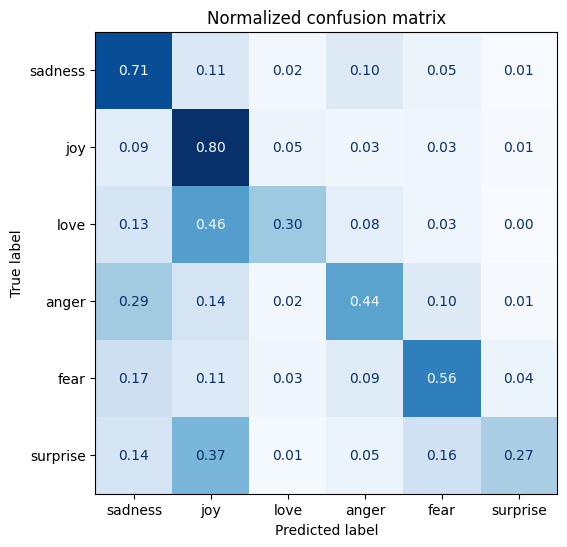

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)